In [24]:
import numpy as np
import pandas as pd
import h5py
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from statistics import mean
import scipy
from pathlib import Path
import math
from scipy.optimize import curve_fit,least_squares
from scipy.interpolate import interp1d
from scipy.optimize import Bounds
from scipy.fft import fft, fftfreq
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal 
from scipy.signal import lombscargle
import operator
import riip

In [30]:
#Plotting Options
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.style.use('seaborn-whitegrid')

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["font.family"] = "Times"

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#make colormap indicating cloud phase
liquid = cm.get_cmap('Reds_r', 60)
mixed = cm.get_cmap('RdPu_r', 90)
ice = cm.get_cmap('PuBu_r', 120)

## Refractive Index

Import refractive index data to build expected retardance arrays

In [27]:
ri = riip.RiiDataFrame()

In [158]:
ri.search("glass")

,book,section,page,formula,tabulated,wl_min,wl_max
id,,,,,,,
1014,soda-lime,,Rubin-clear,5,k,0.310000,4.60000
1015,soda-lime,,Rubin-bronze,5,k,0.320000,4.60000
1016,soda-lime,,Rubin-grey,5,k,0.320000,4.60000
1017,soda-lime,,Rubin-green,5,k,0.320000,4.60000
1018,soda-lime,,Rubin-lowiron,5,k,0.310000,4.60000
1019,soda-lime,,Rubin-IR,0,nk,5.000000,300.00000
1020,soda-lime,,Vogt-5ppm,0,nk,0.300000,1.69000
1021,soda-lime,,Vogt-10ppm,0,nk,0.250000,1.70000
1022,soda-lime,,Vogt-703ppm,0,nk,0.300000,1.69000


In [42]:
water = ri.material({'id': 428})
water273 = ri.material({'id': 450})
water263 = ri.material({'id': 449})
water253 = ri.material({'id': 448})
ice = ri.material({'id': 438})

glass = ri.material({'id': 1019})
nacl = ri.material({'id': 183})
wls = np.linspace(6, 16,200)

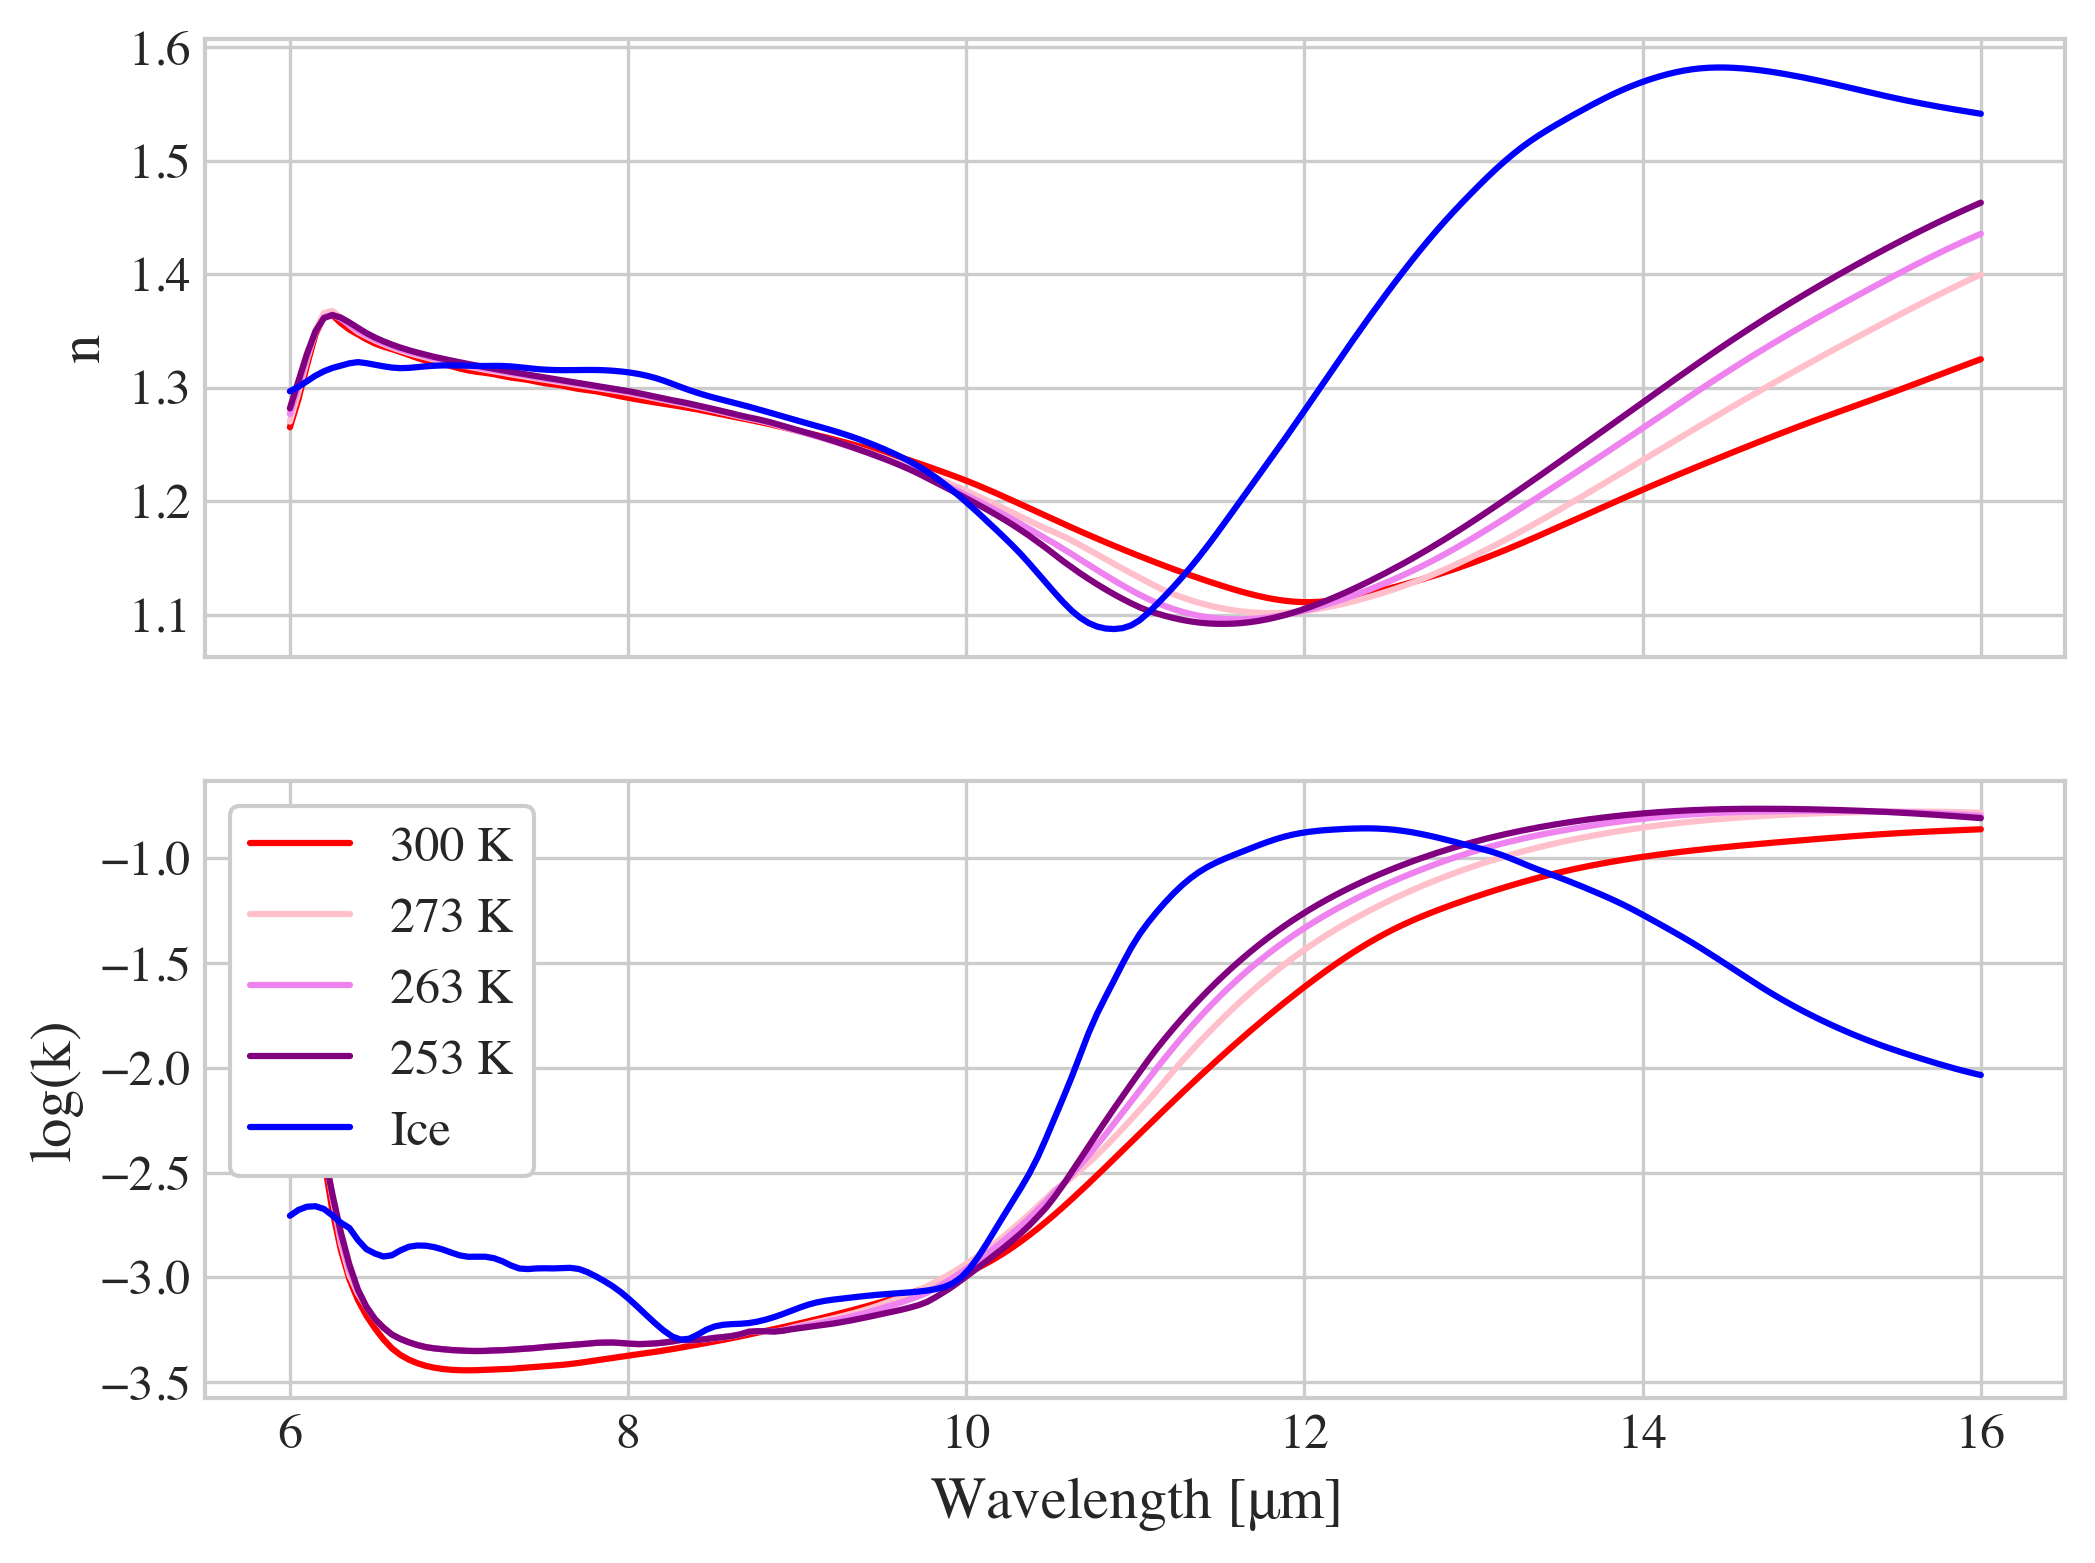

In [47]:
fig, axs = plt.subplots(2,figsize = (8,6),sharex = True)
axs[0].plot(wls,water.n(wls),'r',label = '300 K')
axs[0].plot(wls,water273.n(wls),'pink',label = '273 K')
axs[0].plot(wls,water263.n(wls),'violet',label = '263 K')
axs[0].plot(wls,water253.n(wls),'purple',label = '253 K')
axs[0].plot(wls,ice.n(wls),'blue',label = 'Ice')
#axs[0].set_xlabel('Wavelength [$\mathdefault{\mu}$m]')
axs[0].set_ylabel('n')


axs[1].plot(wls,np.log(water.k(wls)),'r',label = '300 K')
axs[1].plot(wls,np.log(water273.k(wls)),'pink',label = '273 K')
axs[1].plot(wls,np.log(water263.k(wls)),'violet',label = '263 K')
axs[1].plot(wls,np.log(water253.k(wls)),'purple',label = '253 K')
axs[1].plot(wls,np.log(ice.k(wls)),'blue',label = 'Ice')
axs[1].set_xlabel('Wavelength [$\mathdefault{\mu}$m]')
axs[1].set_ylabel('log(k)')

plt.gcf().set_dpi(300)
legend =axs[1].legend(facecolor='white', framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')

plt.show()

In [122]:
theta = 1.1
n = water.n(wls)
def getEmissivityS(n,theta):
    thetar = np.arcsin(np.sin(theta)/n)
    RS = np.abs((np.cos(theta)- n*np.cos(thetar))/(np.cos(theta)+ n*np.cos(thetar)))**2
    return(1-RS)
    
def getEmissivityP(n,theta):
    thetar = np.arcsin(np.sin(theta)/n)
    RP = np.abs((n*np.cos(theta)- np.cos(thetar))/(n*np.cos(theta)+ np.cos(thetar)))**2
    return(1-RP)

def getDOLP(n,theta):
    ep = getEmissivityP(n,theta)
    es = getEmissivityS(n,theta)
    return((es-ep)/(es+ep))
    #return (es+ep)/2
    
def getE(n,theta):
    ep = getEmissivityP(n,theta)
    es = getEmissivityS(n,theta)
    return (es+ep)/2

def getDOLPR(n,theta):
    ep = 1-getEmissivityP(n,theta)
    es = 1-getEmissivityS(n,theta)
    #return (es+ep)/2
    return((es-ep)/(es+ep))

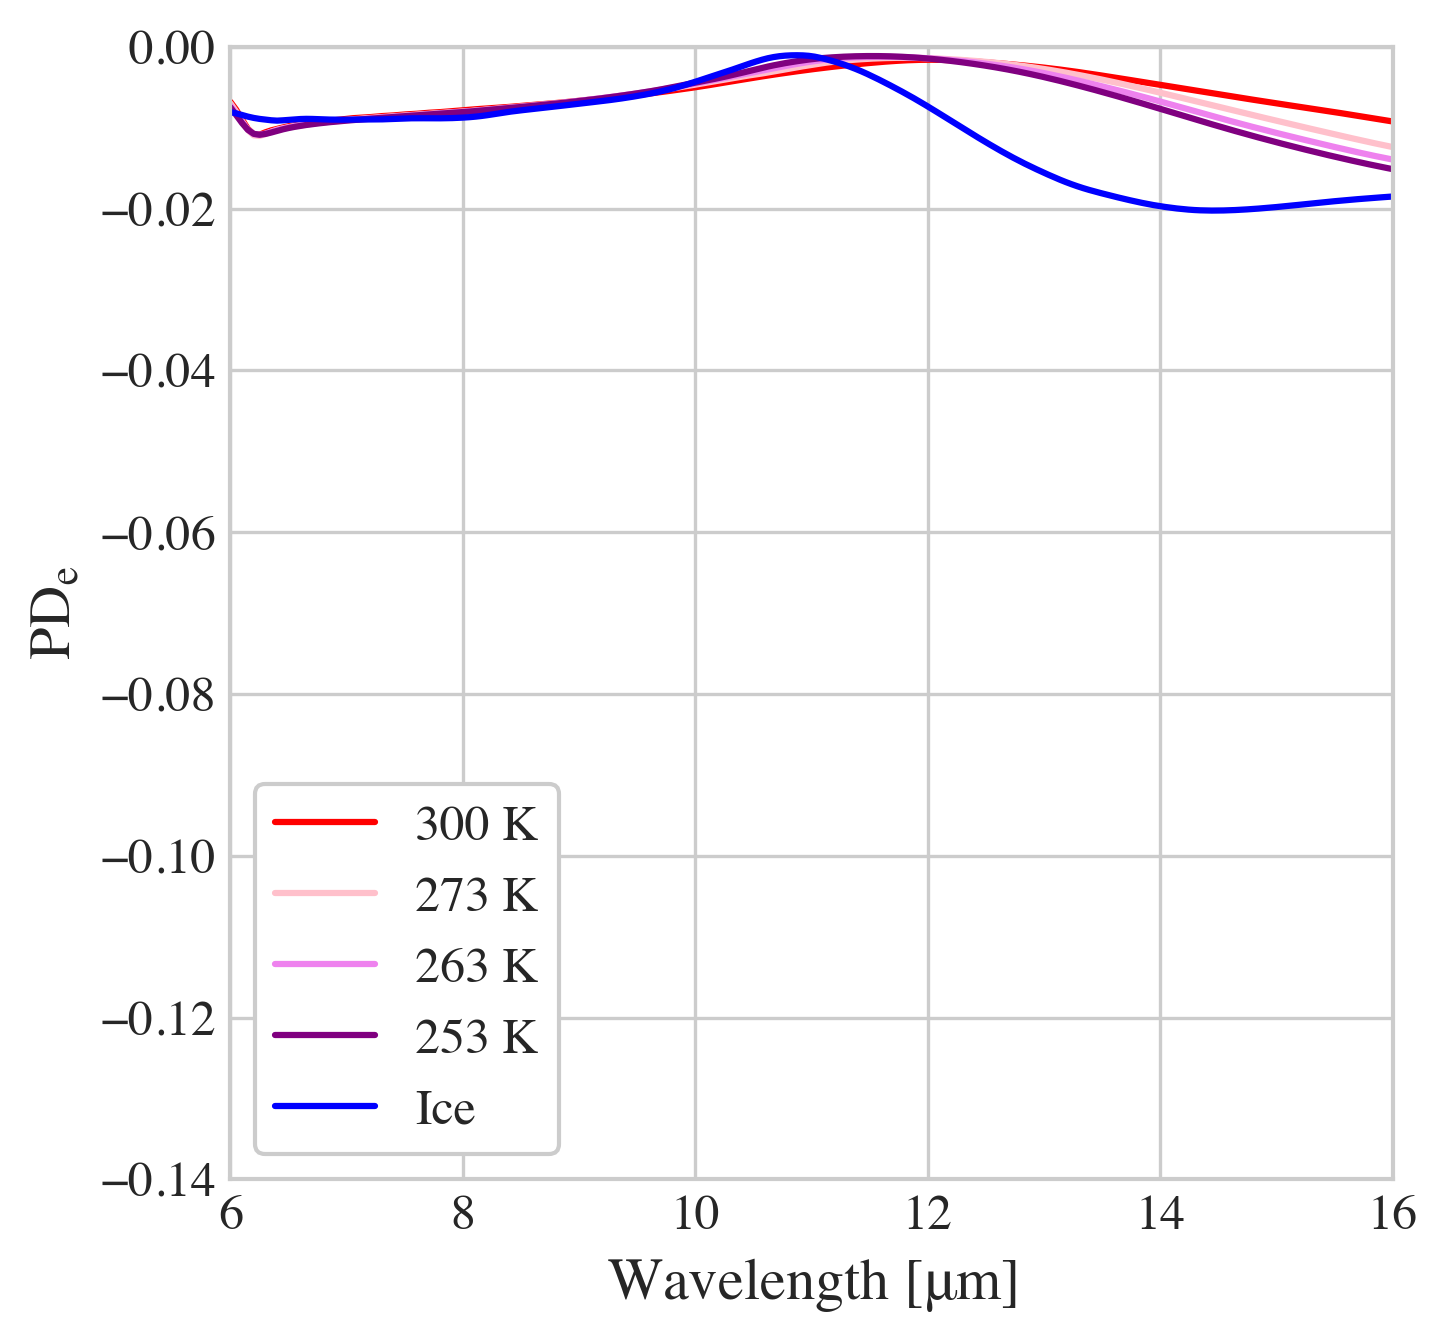

In [66]:
theta = .52
fig, axs = plt.subplots(1,figsize = (5,5),sharex = True)
plt.plot(wls,getDOLP(water.n(wls),theta),'r',label = '300 K')
plt.plot(wls,getDOLP(water273.n(wls),theta),'pink',label = '273 K')
plt.plot(wls,getDOLP(water263.n(wls),theta),'violet',label = '263 K')
plt.plot(wls,getDOLP(water253.n(wls),theta),'purple',label = '253 K')
plt.plot(wls,getDOLP(ice.n(wls),theta),'blue',label = 'Ice')
plt.plot(wls,getDOLP(ice.n(wls),theta),'blue',label = 'Ice')

#plt.plot(wls,getDOLP(water.n(wls),theta),'r',label = '300 K')
#plt.plot(wls,getDOLP(water273.n(wls),theta),'pink',label = '273 K')
#plt.plot(wls,getDOLP(water263.n(wls),theta),'violet',label = '263 K')
#plt.plot(wls,getDOLP(water253.n(wls),theta),'purple',label = '253 K')
#plt.plot(wls,getDOLP(ice.n(wls),theta),'blue',label = 'Ice')


legend =plt.legend(facecolor='white', framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
#plt.title('$\mathdefault{\\theta _e = 50}^\circ$',fontsize = 20)
plt.ylabel('$\mathdefault{PD_e}$')
plt.xlim(6,16)
plt.ylim(-.14,0)
#plt.plot([0,100],[0,0],'k')
plt.xlabel('Wavelength [$\mathdefault{\mu}$m]')

plt.gcf().set_dpi(300)


/Users/kirahart/opt/anaconda3/envs/database/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in arcsin
  if __name__ == '__main__':
/Users/kirahart/opt/anaconda3/envs/database/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in arcsin
  after removing the cwd from sys.path.


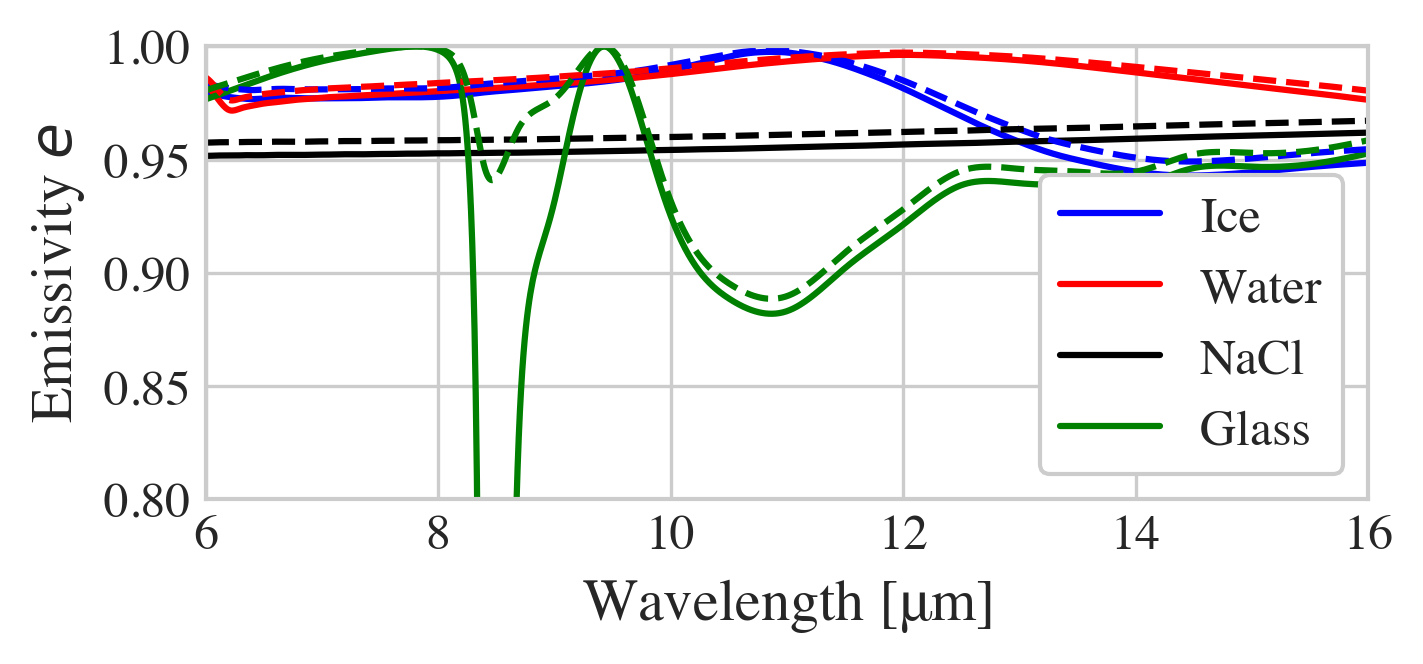

In [157]:
theta = 40 * np.pi/180
theta2 = 10 *np.pi/180
fig, axs = plt.subplots(1,figsize = (5,2),sharex = True)

plt.plot(wls,getE(ice.n(wls),theta),'b-', label = 'Ice')
plt.plot(wls,getE(water.n(wls),theta),'r-', label = 'Water')
plt.plot(wls,getE(nacl.n(wls),theta),'k-', label = 'NaCl')
plt.plot(wls,getE(glass.n(wls),theta),'g-',label = 'Glass ')

plt.plot(wls,getE(ice.n(wls),theta2),'b--')
plt.plot(wls,getE(water.n(wls),theta2),'r--')
plt.plot(wls,getE(nacl.n(wls),theta2),'k--')
plt.plot(wls,getE(glass.n(wls),theta2),'g--')


legend =plt.legend(facecolor='white', framealpha=1, frameon=True,loc = "lower right")
legend.get_frame().set_facecolor('w')
#plt.title('$\mathdefault{\\theta _e = 50}^\circ$',fontsize = 20)
plt.ylabel('Emissivity $e$')
plt.xlim(6,16)
plt.ylim(.8,1)
#plt.plot([0,100],[0,0],'k')
plt.xlabel('Wavelength [$\mathdefault{\mu}$m]')

plt.gcf().set_dpi(300)

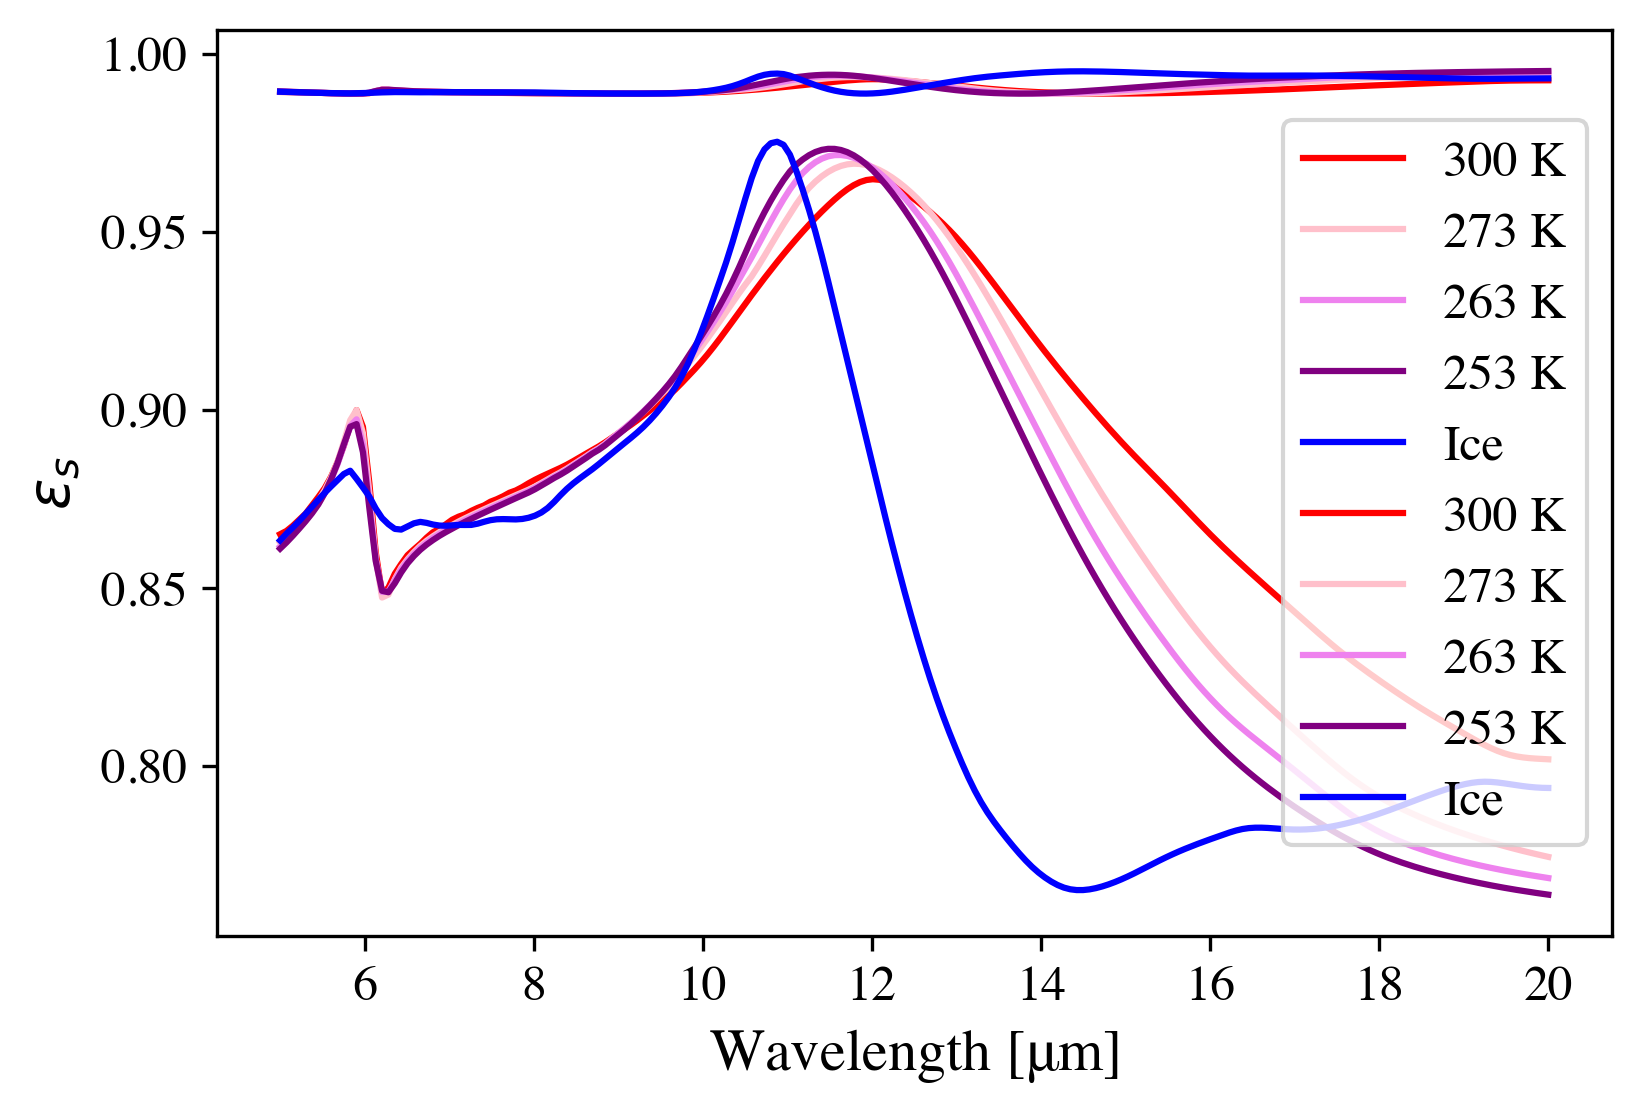

In [340]:

plt.plot(wls,getEmissivityP(water.n(wls),theta),'r',label = '300 K')
plt.plot(wls,getEmissivityP(water273.n(wls),theta),'pink',label = '273 K')
plt.plot(wls,getEmissivityP(water263.n(wls),theta),'violet',label = '263 K')
plt.plot(wls,getEmissivityP(water253.n(wls),theta),'purple',label = '253 K')
plt.plot(wls,getEmissivityP(ice.n(wls),theta),'blue',label = 'Ice')
#axs[0].set_xlabel('Wavelength [$\mathdefault{\mu}$m]')

plt.plot(wls,getEmissivityS(water.n(wls),theta),'r',label = '300 K')
plt.plot(wls,getEmissivityS(water273.n(wls),theta),'pink',label = '273 K')
plt.plot(wls,getEmissivityS(water263.n(wls),theta),'violet',label = '263 K')
plt.plot(wls,getEmissivityS(water253.n(wls),theta),'purple',label = '253 K')
plt.plot(wls,getEmissivityS(ice.n(wls),theta),'blue',label = 'Ice')
plt.xlabel('Wavelength [$\mathdefault{\mu}$m]')
plt.ylabel('$\epsilon_s$')
plt.gcf().set_dpi(300)
plt.legend()
plt.show()

In [120]:
angles = np.linspace(20*np.pi/180,np.pi/2-.001,1000)
wls = np.linspace(6,16,1000)
es = [];rs = []; ep = [];rp = [];dolpe =[];dolpr=[]
mat = glass
for a in angles:
    es.append(getEmissivityS(mat.n(wls),a))
    ep.append(getEmissivityP(mat.n(wls),a))
    rs.append(1-getEmissivityS(mat.n(wls),a))
    rp.append(1-getEmissivityP(mat.n(wls),a))
    dolpe.append(getDOLP(mat.n(wls),a))
    dolpr.append(getDOLPR(mat.n(wls),a))

/Users/kirahart/opt/anaconda3/envs/database/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in arcsin
  after removing the cwd from sys.path.
/Users/kirahart/opt/anaconda3/envs/database/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in arcsin
  if __name__ == '__main__':


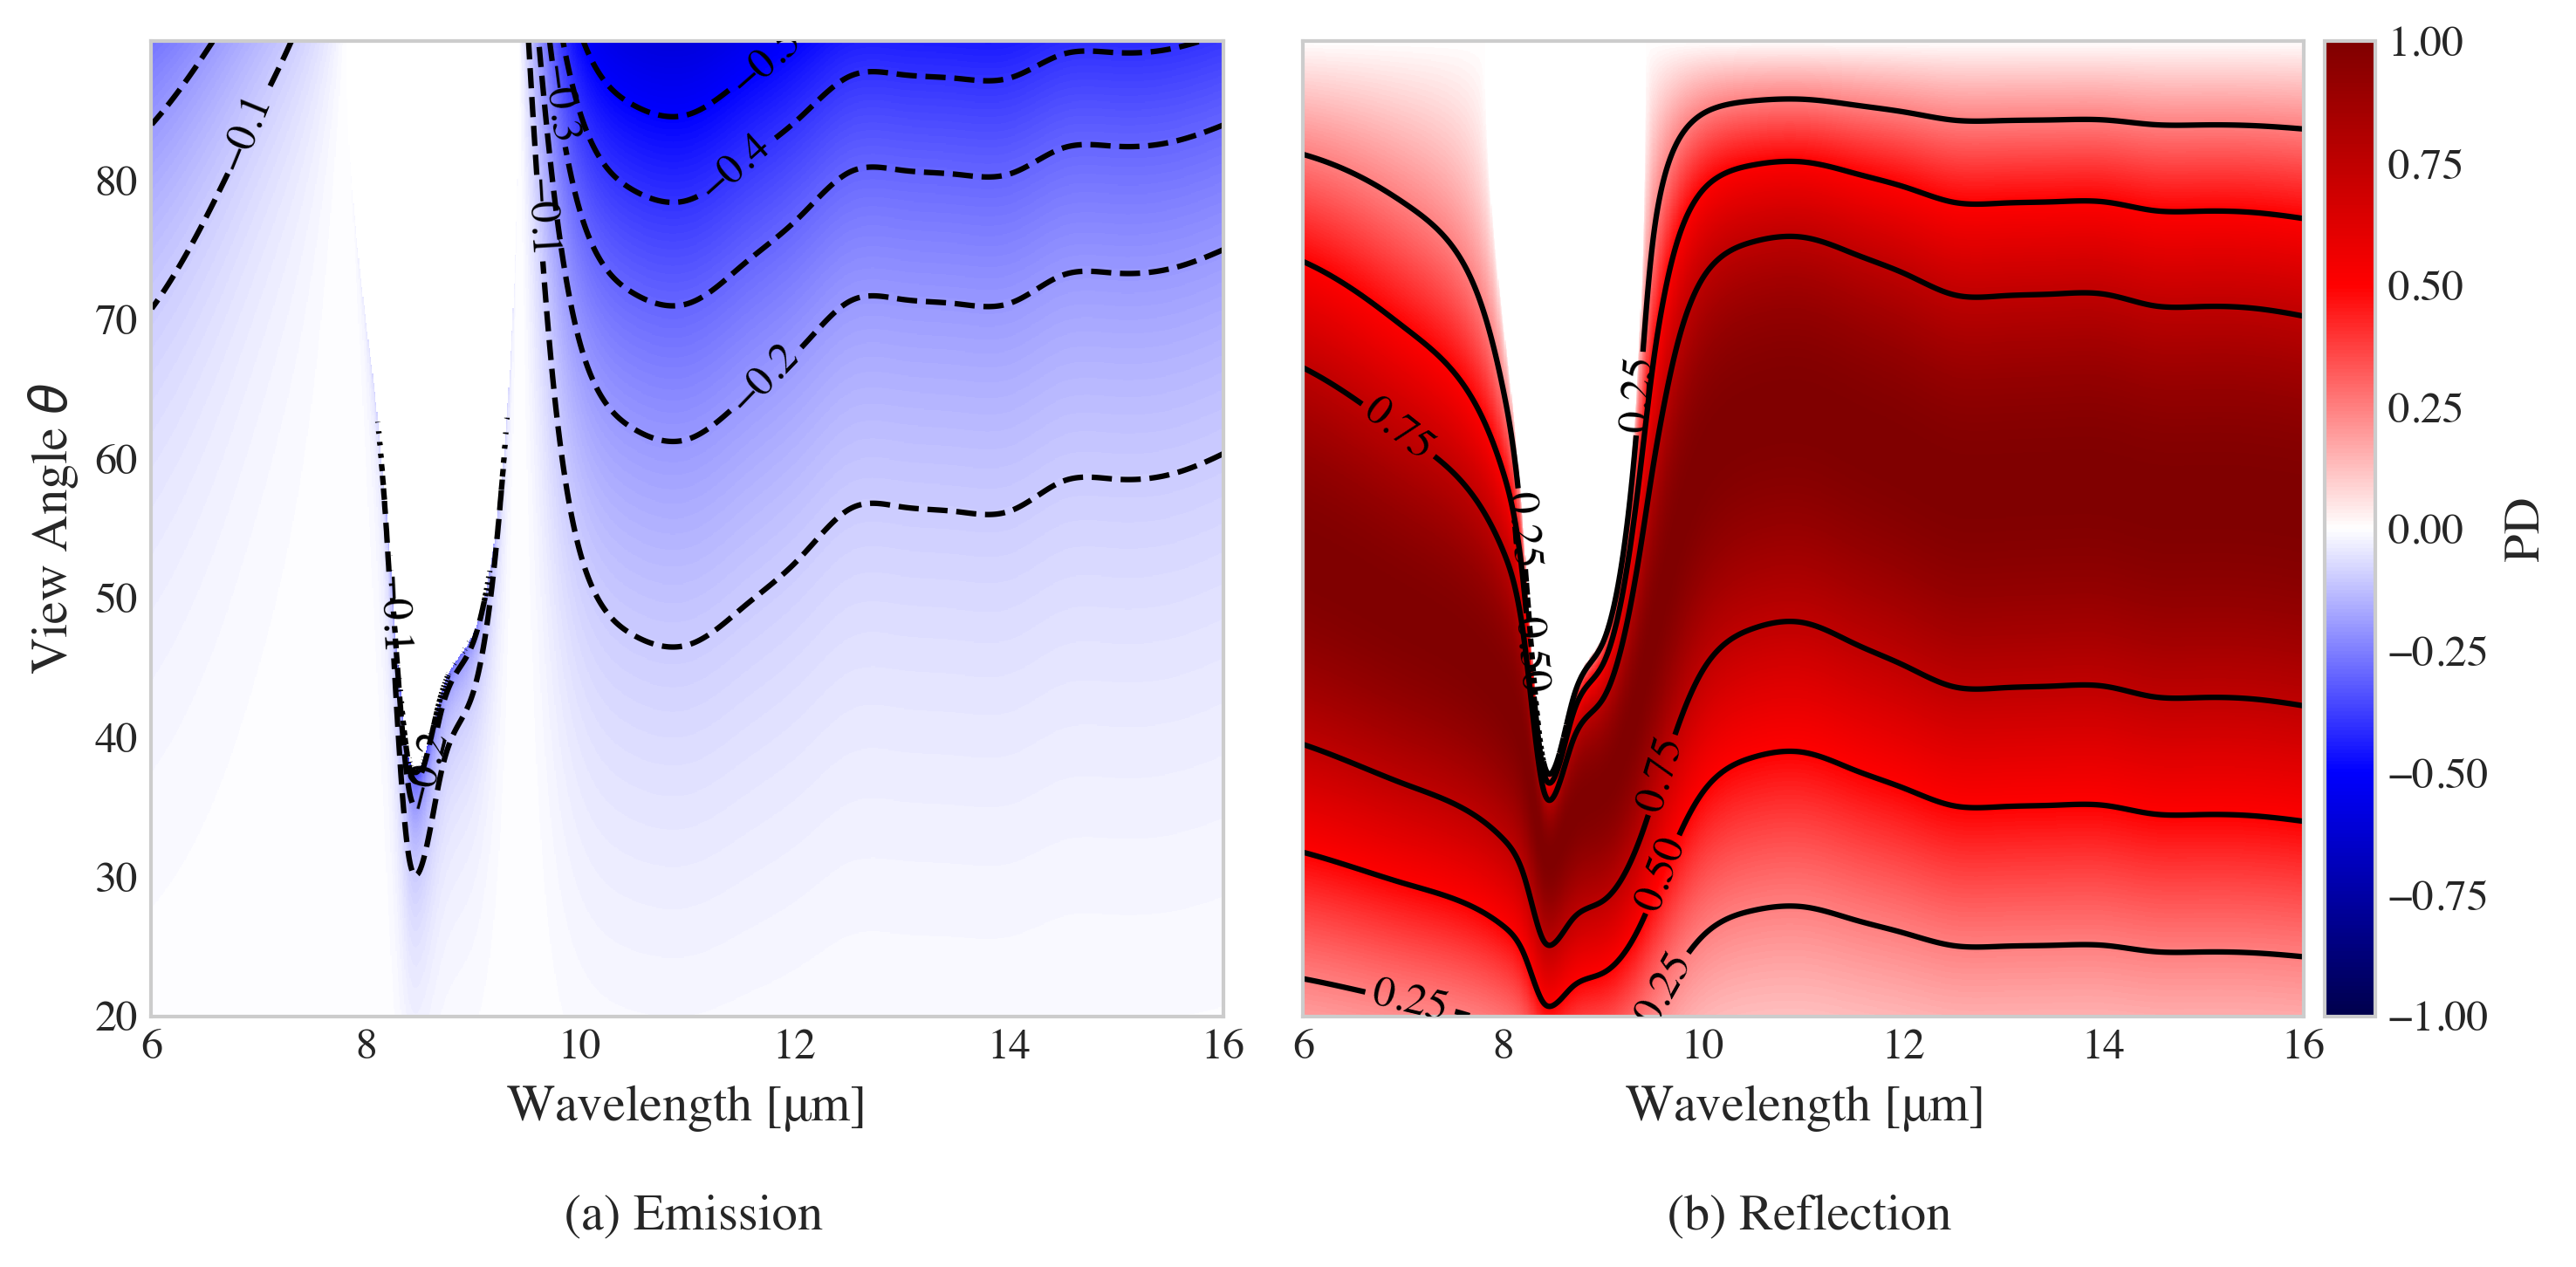

In [121]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs = plt.subplots(1,2,sharex = True,sharey = True,figsize = (10,5))
plt.gcf().set_dpi(300)


im1 = axs[0].pcolormesh(wls,angles*180/np.pi,dolpe,shading='auto',cmap = 'seismic',vmin = -1,vmax = 1)
contours1 = axs[0].contour(wls,angles*180/np.pi,dolpe,5, colors='black')
plt.clabel(contours1, inline=True, fontsize=12)

im2 = axs[1].pcolormesh(wls,angles*180/np.pi,dolpr,shading='auto',cmap = 'seismic',vmin = -1,vmax = 1)
contours2 = axs[1].contour(wls,angles*180/np.pi,dolpr,3, colors='black')
plt.clabel(contours2, inline=True, fontsize=12)

axs[0].set_xlabel('Wavelength [$\mathdefault{\mu}$m] \n \n (a) Emission')
axs[1].set_xlabel('Wavelength [$\mathdefault{\mu}$m]\n \n (b) Reflection')
axs[0].set_ylabel('View Angle $\\theta$')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.08)
fig.colorbar(im2, cax=cax, orientation='vertical',label = "PD")
plt.tight_layout()



plt.show()


## MIE Scattering


In [86]:
import miepython

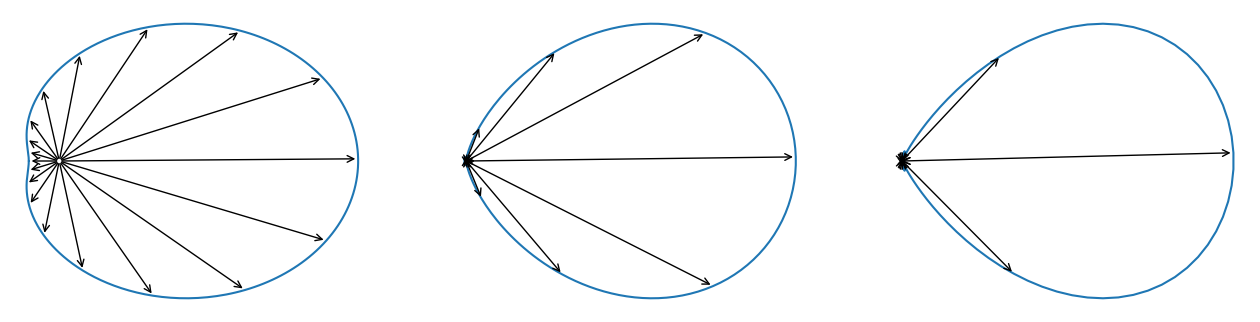

In [88]:
fig,ax=plt.subplots(1,3,figsize=(16,4))
waves=[ 8,9,10,11]
r = 5
plt.scatter([0],[0],s=r)
plt.gcf().set_dpi(100)

r=[2.5,5,10]


for j in range(3):
    mice = ice.n(11)-ice.k(11)*1j
    mwater = water.n(11)-water.k(11)*1j

    x = 2*np.pi*r[j]/11
    theta = np.linspace(-180,180,360)
    theta_r = np.radians(theta)

    mu = np.cos(theta_r)
    scatice = miepython.i_per(mice,x,mu)
    scatwater = miepython.i_per(mwater,x,mu)

    ax[j].plot(scatice*np.cos(theta/180*np.pi),scatice*np.sin(theta/180*np.pi),label = str(waves[j]))
    
    #ax[j].plot(scatwater*np.cos(theta/180*np.pi),scatwater*np.sin(theta/180*np.pi),label = str(waves[j]))
    #ax[j].set_ylim(-.1,.1)
    #ax[j].set_xlim(-.1,1)
    
    for i in range(18):
        ii = i*20
        xx = scatice[ii]*np.cos(theta_r[ii])
        yy = scatice[ii]*np.sin(theta_r[ii])
    #    print(xx,yy)
        ax[j].annotate('',xy=(xx,yy),xytext=(0,0),arrowprops=dict(arrowstyle="->",color='k'))
        ax[j].axis('off')
    


    ax[j].set_ylabel("$\mathdefault{\lambda} = $ " +str(waves[j])+" $\mathdefault{\mu}$m")
plt.show()


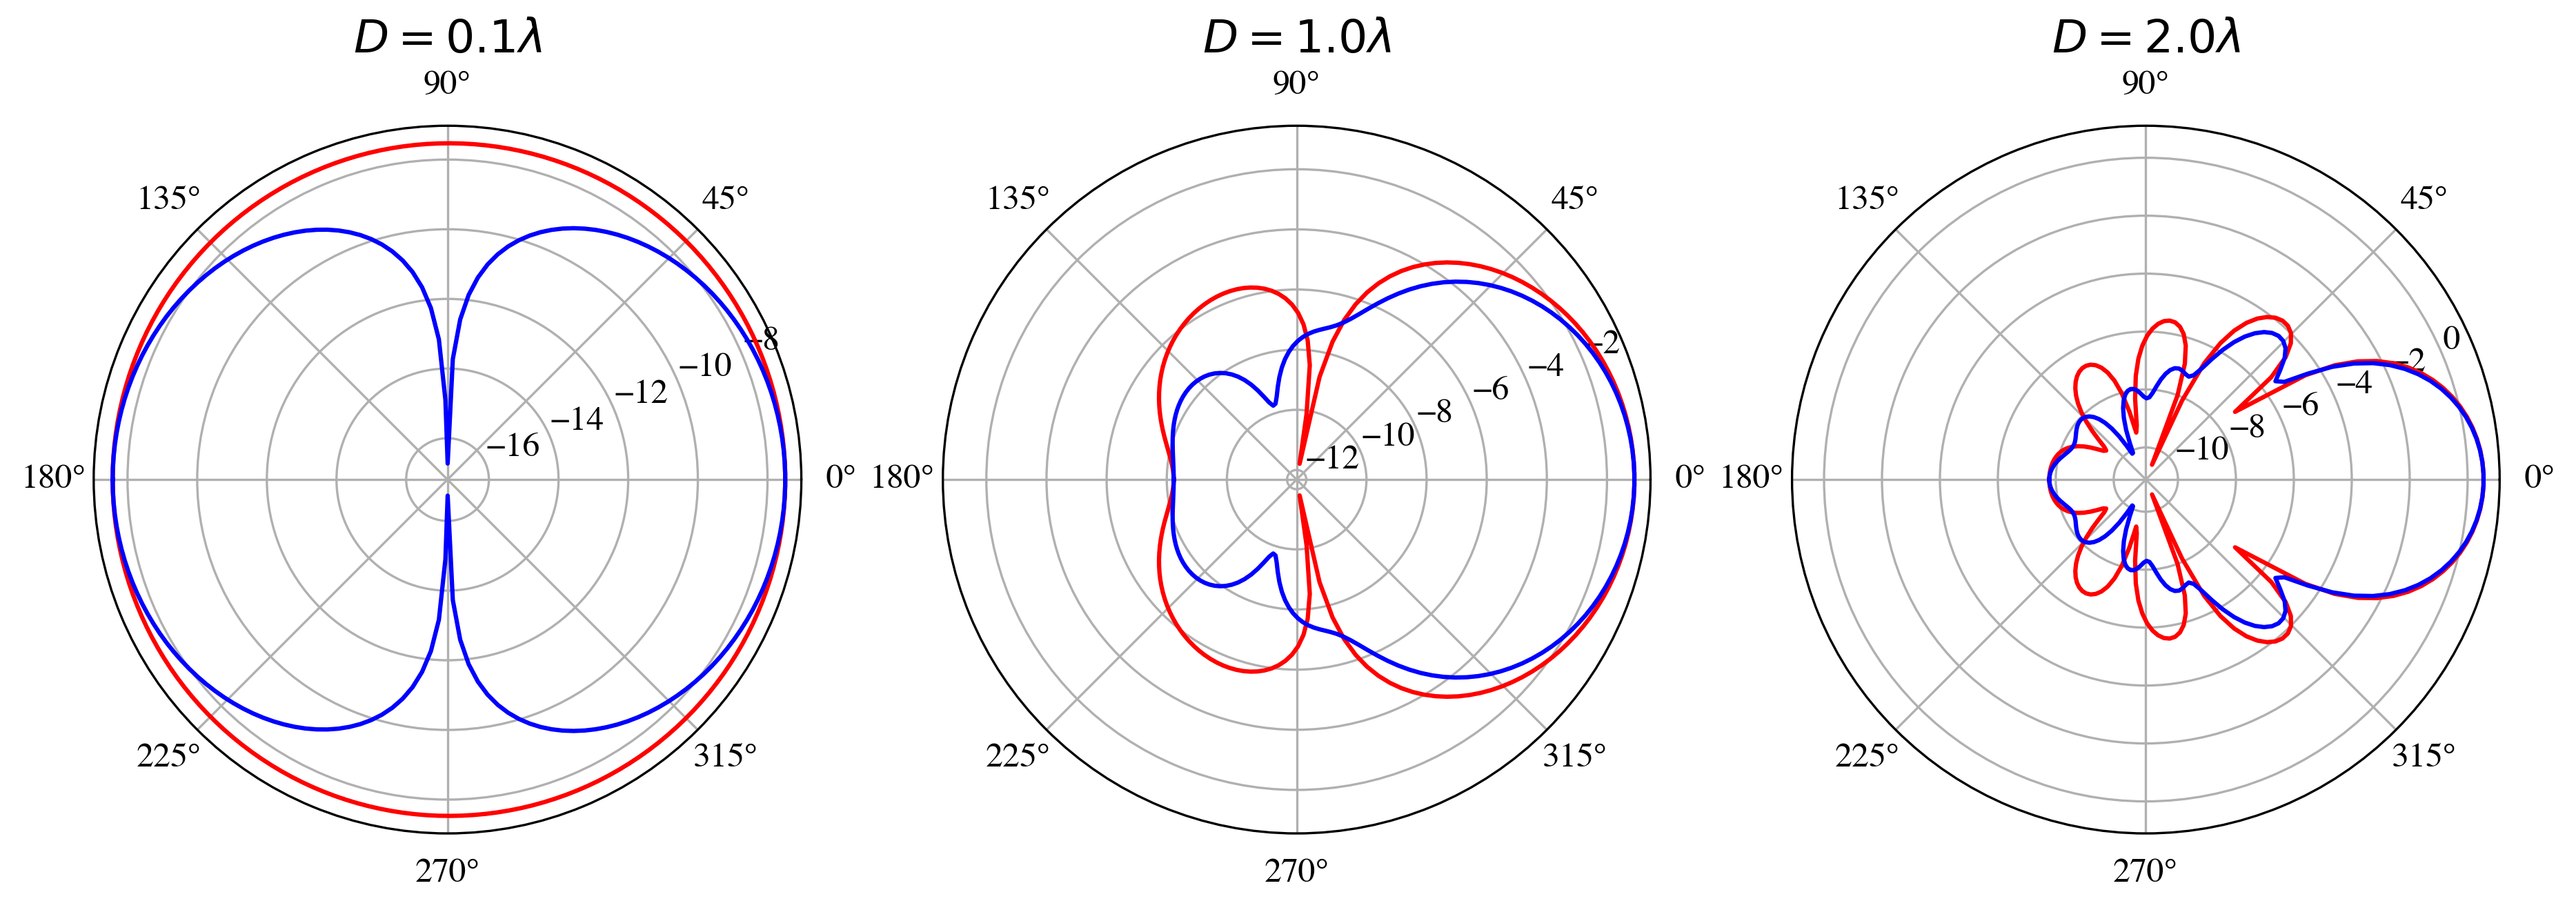

In [604]:
rs = [.55,5.5,11]
fig,ax = plt.subplots(1,3,figsize=(15,5),subplot_kw=dict(polar=True))
for i in range(3):
    N=500
    w = 11
    m = water.n(w)-water.k(w)*1j
    r = rs[i]
    x = 2*np.pi*r/w

    theta = np.linspace(-180,180,180)
    mu = np.cos(theta/180*np.pi)
    ipar = miepython.i_par(m,x,mu)
    iper = miepython.i_per(m,x,mu)
    #iun  = miepython.i_unpolarized(m,x,mu)

   
    ax[i].plot(theta/180*np.pi,np.log(iper),'r')
    ax[i].plot(theta/180*np.pi,np.log(ipar),'b')
    ax[i].set_title("$D = "+  str(2*r/w)+ " \lambda $",fontsize = 16)

plt.gcf().set_dpi(300)


plt.show()


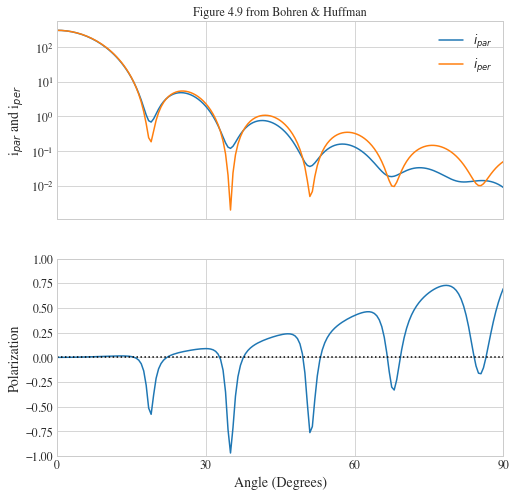

In [89]:
w = 11
m = water.n(w)-water.k(w)*1j
r = 20
x = 2*np.pi*r/w


theta = np.linspace(0,90,181)
mu = np.cos(theta*np.pi/180)

scaling_factor = 16*np.pi
iper = scaling_factor*miepython.i_per(m,x,mu)
ipar = scaling_factor*miepython.i_par(m,x,mu)
iunpol = scaling_factor*miepython.i_unpolarized(m,x,mu)

P = (iper-ipar)/(iper+ipar)

plt.subplots(2,1,figsize=(8,8),sharex = True)
plt.subplot(2,1,1)
plt.semilogy(theta,ipar,label='$i_{par}$')
plt.semilogy(theta,iper,label='$i_{per}$')
plt.xlim(0,90)
plt.xticks(range(0,181,30))
plt.ylabel('i$_{par}$ and i$_{per}$')
plt.legend()
plt.title('Figure 4.9 from Bohren & Huffman')
plt.subplot(2,1,2)
plt.plot(theta,P)
plt.ylim(-1,1)
plt.xticks(range(0,181,30))
plt.xlim(0,90)
plt.ylabel('Polarization')
plt.plot([0,180],[0,0],':k')
plt.xlabel('Angle (Degrees)')
plt.show()

In [114]:
polarizations = []

intensity = []
for w in wls:
    m = water.n(w)-water.k(w)*1j
    r = 10
    x = 2*np.pi*r/w


    theta = np.linspace(0,180,281)
    mu = np.cos(theta*np.pi/180)

    scaling_factor = 16*np.pi
    iper = scaling_factor*miepython.i_per(m,x,mu)
    ipar = scaling_factor*miepython.i_par(m,x,mu)
    P = (iper-ipar)/(iper+ipar)
    polarizations.append(P)
    intensity.append((iper+ipar))


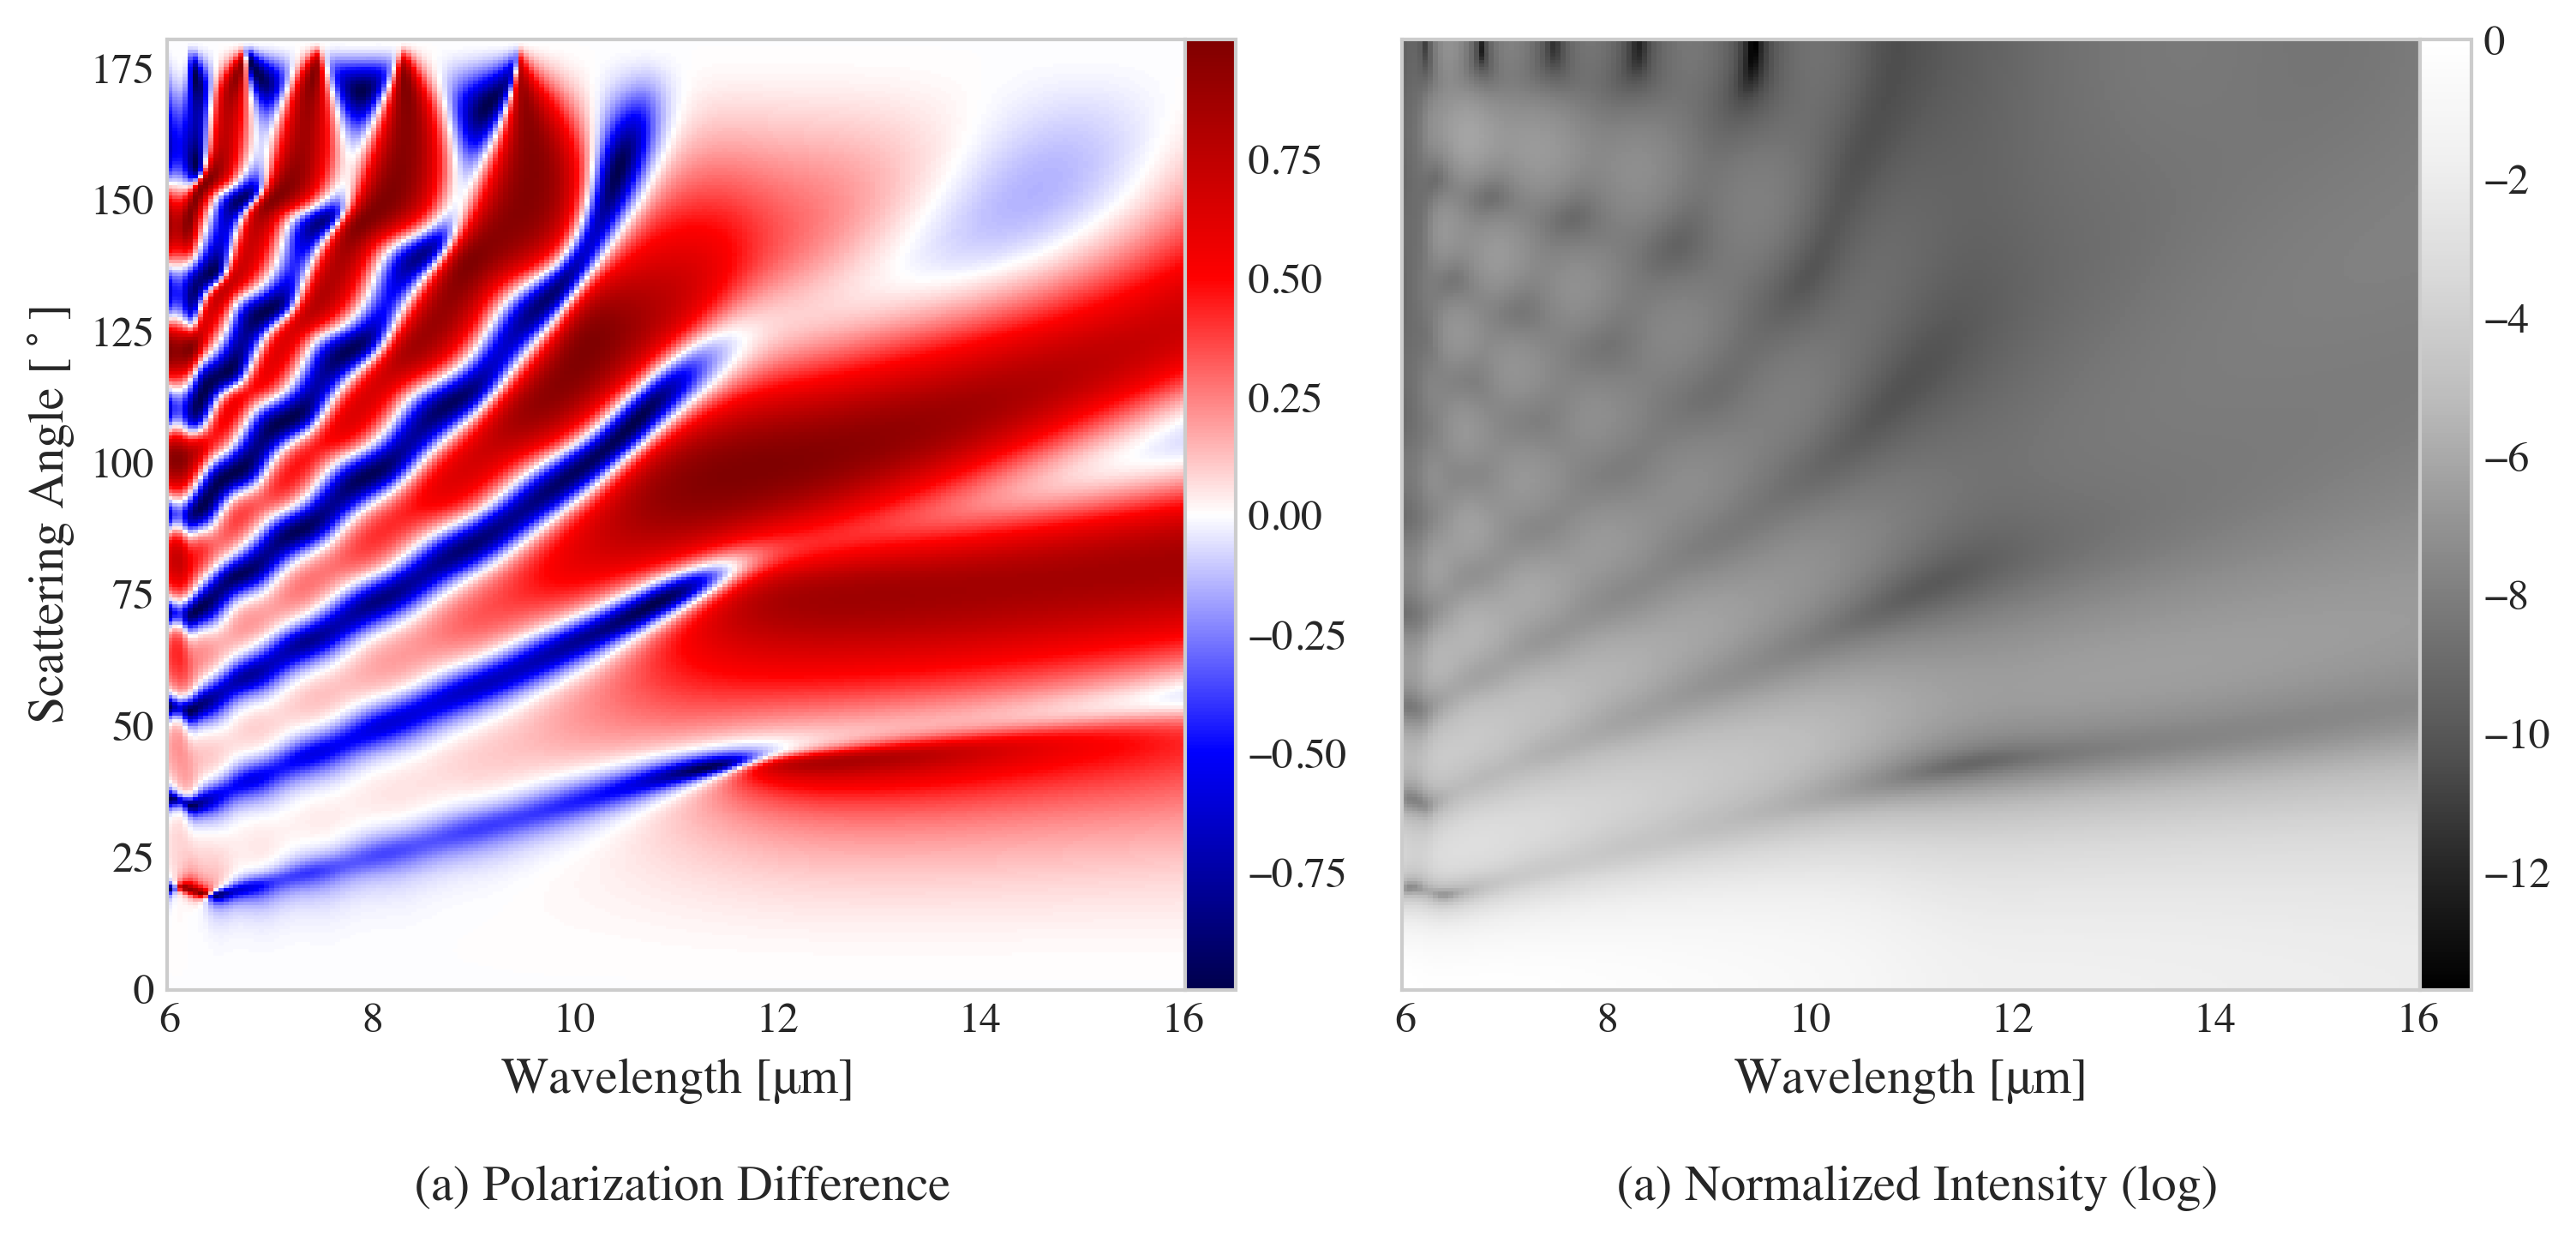

In [115]:
fig, axs = plt.subplots(1,2,sharex = True,sharey = True,figsize = (10,5))
import matplotlib as mpl


im1=axs[0].pcolormesh(wls,theta,np.transpose(polarizations), shading='auto',cmap = "seismic")
axs[0].set_xlabel('Wavelength [$\mathdefault{\mu}$m]\n \n (a) Polarization Difference')
axs[0].set_ylabel('Scattering Angle [$^\circ $]')

im2=axs[1].pcolormesh(wls,theta,np.transpose(np.log(intensity/np.max(intensity))),shading='auto',cmap = "Greys_r")
axs[1].set_xlabel('Wavelength [$\mathdefault{\mu}$m] \n \n (a) Normalized Intensity (log)')

divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0)
fig.colorbar(im1, cax=cax, orientation='vertical')
plt.tight_layout()
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0)
fig.colorbar(im2, cax=cax, orientation='vertical')
plt.gcf().set_dpi(300)

plt.show()